# Dipole radiation in a planar metal structure
In a planar structure, the dielectric function $\epsilon(\omega,\mathbf{r})$ is spatially only a function of $z$, that is, $\epsilon(\omega,\mathbf{r}) = \epsilon(\omega,z)$ Thus, the system (geometry + materials) has the azimuthal symmetry. We can exploit this property to reduce computation.  
Any $E$-field can be expressed as
$$ \mathbf{E}(r,\phi,z) = \sum_{m=0}^{\infty} \mathbf{E}_m(r,z) e^{i m \phi} $$

In the cylindrical simulation, the computation of the total fields
is splitted into separate computations of theri respective $m$.
In the simulation class, we have to specify $m$. 
For example, the following code takes only fields of $m=-1$ into account.

```python
mp.Simulation(resolution=resolution,
              cell_size=cell_size,
              boundary_layers=pml_layers,
              sources=sources,
              dimensions=mp.CYLINDRICAL,
              m=-1
              )
```
In this case, even if you set  a `source` with contains other $m$'s, the simulation will only compute the component of $m=-1$.

In this simulation, we consider a $x$-dipole at Origin, whose total field contain every $m$ term. However, for the far-field radiation, we only need to consider $m= \pm 1$ (Why? Eq. 9.130 from Jackson. Conceptially, becuase there is only dipole moment). Moreover, because contributions from $m=\pm1$ are equal, we need only the case $m=-1$



In [299]:
import meep as mp
from meep.materials import Al, Ag, Au, SiO2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from time import perf_counter
print(mp.__version__)

## import my colormap
import mycmapls as ms
mycmap = ms.mycmap
mycmap1 = ms.mycmap1
mycmap2 = ms.mycmap2


1.24.0


In [300]:
resolution = 100  # pixels/μm for metal > 90 

dpml = 0.5       # thickness of PML
h = 3# height
w = 12
L = 3.0          # length of non-PML region
n = 1          # vaccum refractive index
wvl = 1.0        # wavelength (in vacuum)

fcen = 1/wvl


In [301]:
def bulk_ldos_cyl(m):
    if np.abs(m)>1:
        courant =  1/2/(np.abs(m)+1)
    else:
        courant = 0.5
    
    sr = w+dpml
    sz = h+2*dpml
    cell_size = mp.Vector3(sr,0,sz)

    pml_layers = [mp.PML(dpml)]

    sources = [mp.Source(src=mp.GaussianSource(fcen,fwidth=1),
                         component=mp.Er,
                         center=mp.Vector3(0))]

    sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=pml_layers,
                        sources=sources,
                        dimensions=mp.CYLINDRICAL,
                        m=m,
                        Courant = courant,
                       # accurate_fields_near_cylorigin= True,# we have a dipole at Origin!!
                        default_material=mp.Medium(index=n))

    sim.run(mp.dft_ldos(fcen,0,1),
            until_after_sources=mp.stop_when_fields_decayed(5,
                                                            mp.Er,
                                                            mp.Vector3(),
                                                            1e-6))

    return sim.ldos_data[0]

def metal_cavity_ldos_cyl(g,m):
    if np.abs(m)>1:
        courant =  1/2/(np.abs(m)+1)
    else:
        courant = 0.5
    sz = h+2*dpml
    sr = w+dpml
    geometry = [mp.Block(center=mp.Vector3( w/2, 0 , g/2),
                        size=mp.Vector3(w,0,0.01),
                        material=Ag),
                mp.Block(center=mp.Vector3( w/2, 0 , -g/2),
                        size=mp.Vector3(w,0,0.01),
                        material=Ag)
               ]
    cell_size = mp.Vector3(sr,0,sz)

    pml_layers = [mp.PML(dpml)]

    sources = [mp.Source(src=mp.GaussianSource(fcen,fwidth=1),
                         component=mp.Er,
                         center=mp.Vector3())]

    sim = mp.Simulation(resolution=resolution,
                        cell_size=cell_size,
                        boundary_layers=pml_layers,
                        sources=sources,
                        geometry=geometry,
                        dimensions=mp.CYLINDRICAL,
                        m=m,
                        default_material=mp.Medium(index=n))

    sim.run(mp.dft_ldos(fcen,0,1),
            until_after_sources=mp.stop_when_fields_decayed(5,
                                                            mp.Er,
                                                            mp.Vector3(),
                                                            1e-6))

    return sim.ldos_data[0]

In [266]:
%%capture
import time
import numpy as np
from joblib import Parallel, delayed
nc = 2 ## number of processes

start =  time.time()
##

ldos_bulk_cyl = bulk_ldos_cyl(1)

# units of wavelength in cavity medium
cavity_thickness = np.arange(0.50,2.55,0.05)

gap = cavity_thickness*wvl/n

ldos_metal_cavity_cyl = np.zeros(len(cavity_thickness))

with Parallel(n_jobs=nc) as parallel:
     ldos_metal_cavity_cyl = parallel([delayed(metal_cavity_ldos_cyl)(gap[i], 1) for i in range(len(gap))])

ldos_metal_cavity_cyl = np.array(ldos_cavity_cyl)

# for idx,g in enumerate(gap):
#     ldos_metal_cavity_cyl[idx] = metal_cavity_ldos_cyl(g,1)
#     # print("purcell-enh:, {:.3f}, " "{:.6f} (cyl.)".format(cavity_thickness[idx],
#     #                                                       ldos_cavity_cyl[idx]/ldos_bulk_cyl))

# Purcell enhancement factor (relative to bulk medium)

pe_metal_cyl = ldos_metal_cavity_cyl / ldos_bulk_cyl


# equation 7 of reference
pe_theory = (3*np.fix(cavity_thickness+0.5)/(4*cavity_thickness) +
             (4*np.power(np.fix(cavity_thickness+0.5),3) -
              np.fix(cavity_thickness+0.5)) /
             (16*np.power(cavity_thickness,3)))
##
end = time.time()

KeyboardInterrupt: 

-984.372479040001


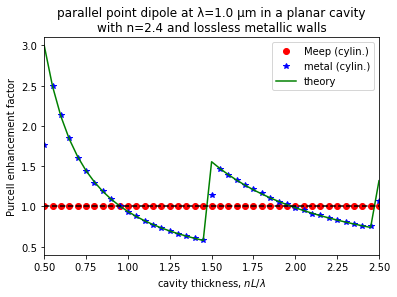

In [270]:
execution_time = (end - start)
print(execution_time)
plt.plot(cavity_thickness,pe_metal_cyl,'b*',label='metal (cylin.)')
plt.plot(cavity_thickness,pe_theory,'g-',label='theory')
plt.plot(cavity_thickness,np.ones(len(cavity_thickness)),'k--')
plt.xlabel('cavity thickness, $nL/\lambda$')
plt.ylabel('Purcell enhancement factor')
plt.title("parallel point dipole at λ=1.0 μm in a planar cavity\n"
          "with n=2.4 and lossless metallic walls")
plt.axis([0.5,2.5,0.4,3.1])
plt.legend()
plt.savefig('cavity_purcell_factor_vs_thickness.png',
            bbox_inches='tight')

In [280]:
sr = w+dpml
sz = h+2*dpml
cell_size = mp.Vector3(sr,0,sz)
g = 1
resolution = 70
geometry = [mp.Block(center=mp.Vector3( w/2, 0 , g/2),
                        size=mp.Vector3(w,0,0.01),
                        material=Ag),
                mp.Block(center=mp.Vector3( w/2, 0 , -g/2),
                        size=mp.Vector3(w,0,0.01),
                        material=Ag)
               ]
pml_layers = [mp.PML(dpml)]

sources = [mp.Source(src=mp.GaussianSource(fcen,fwidth=0.2*fcen),
                     component=mp.Er,
                     center=mp.Vector3(0))]

sim = mp.Simulation(
                    resolution=resolution,
                    cell_size=cell_size,
                    geometry=geometry,
                    boundary_layers=pml_layers,
                    sources=sources,
                    dimensions=mp.CYLINDRICAL,
                    m=1,
                    default_material=mp.Medium(index=n))
sim.restart_fields()    
sim.run( until=25)
# sim.run( until_after_sources=mp.stop_when_fields_decayed(5,
#                                                             mp.Er,
#                                                             mp.Vector3(),
#                                                             1e-6))

TypeError: Simulation.__init__() got an unexpected keyword argument 'Verbosity'

ldos0:, 1.0, 3.86179979257719e-06
run 0 finished at t = 60.01 (12002 timesteps)

Elapsed run time = 598.8111 s
ldos0:, 1.0, 3.86179979257719e-06
run 0 finished at t = 60.01 (12002 timesteps)

Elapsed run time = 1008.2972 s


     block, center = (6,0,0.5)
          size (12,0,0.01)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (6,0,-0.5)
          size (12,0,0.01)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


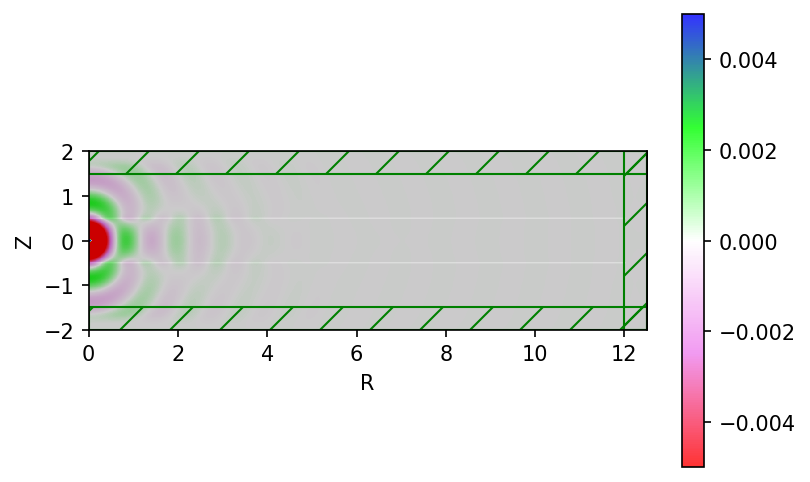

In [269]:
##
Er = sim.get_array(component=mp.Er, vol=mp.Volume(center=mp.Vector3(sr/2,0,0), size=mp.Vector3(sr,0,sz)))
##

nz = Er.shape[0]
nr = Er.shape[1]
zv = np.linspace(-sz/2,sz/2,nz)
rv = np.linspace(0,sr,nr)
rr, zz = np.meshgrid(rv, zv)
plt.figure(dpi=150)
plt.pcolormesh(rr,zz,np.real(Er), cmap=bicmap,alpha= 0.8)
plt.colorbar()
sim.plot2D(eps_parameters={'contour':False},source_parameters={'alpha':0,'color':'white','linewidth':0.5})
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0,sr)
plt.ylim(-sz/2,sz/2)
plt.clim(-0.005,0.005)
plt.show()